<a href="https://colab.research.google.com/github/ScienceFair2018/Adveserial-AI-FRT/blob/main/Adversarial_AI_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install facenet-pytorch

In [ ]:
############ FGSM ########################
epsilon = 0.1

import torch
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import torch.nn.functional as F
from torchvision.transforms.functional import resize
from torchvision.transforms.functional import to_pil_image


def initialize_mtcnn():
    mtcnn = MTCNN(image_size=160, margin=20, min_face_size =40)
    return mtcnn

def initialize_facenet():
    model = InceptionResnetV1(pretrained='vggface2').eval()
    return model

def process_image(image_path, mtcnn):
    image = Image.open(image_path)
    face = mtcnn(image)
    if face is None:
        raise ValueError("No face detected! Try again!")
    return face

def embeddings(model, face_tensor):
    face_tensor = face_tensor.unsqueeze(0)
    with torch.no_grad():
        embedding = model(face_tensor)
    return embedding.squeeze().numpy()

def compare_images(embedding1, embedding2):
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

def gradcam(model, face_tensor, target_layer):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    hook_backward = target_layer.register_backward_hook(backward_hook)
    hook_forward = target_layer.register_forward_hook(forward_hook)

    face_tensor = face_tensor.unsqueeze(0)
    face_tensor.requires_grad = True
    output = model(face_tensor)

    target_neuron = output.mean()
    target_neuron.backward()

    activations = activations[0].detach()
    gradients = gradients[0].detach()

    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
    gradcam = torch.sum(weights * activations, dim=1).squeeze()
    gradcam = torch.relu(gradcam)

    gradcam = gradcam - gradcam.min()
    gradcam = gradcam / gradcam.max()

    hook_backward.remove()
    hook_forward.remove()

    return gradcam

def plot_gradcam(image_path, gradcam, face_tensor):
    gradcam_np = gradcam.numpy()

    # Resize the Grad-CAM to match the original image dimensions
    original_image = Image.open(image_path)
    gradcam_resized = np.array(Image.fromarray(gradcam_np).resize(original_image.size, resample=Image.BILINEAR))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(8, 8))
    plt.imshow(original_image)
    plt.imshow(gradcam_resized, cmap='jet', alpha=0.6)  # Adjust alpha for better focus
    plt.axis('off')
    plt.title("Grad-Cam Visualization")
    plt.show()

def fgsm_attack_with_gradcam(image, epsilon, data_grad, gradcam):

    gradcam = gradcam / gradcam.max()
    gradcam = torch.tensor(gradcam, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

    # Resize Grad-CAM to match gradient tensor dimensions
    gradcam_resized = F.interpolate(gradcam, size=data_grad.shape[1:], mode='bilinear', align_corners=False)

    # Focus gradients using Grad-CAM
    focused_grad = data_grad * gradcam_resized.squeeze(0)  # Remove batch dimension after resizing

    # Create adversarial perturbation
    perturbed_image = image + epsilon * focused_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # Keep pixel values valid
    return perturbed_image


def generate_targeted_adversarial_image(model, face_tensor, gradcam, epsilon):
    face_tensor.requires_grad = True

    # Forward pass
    output = model(face_tensor.unsqueeze(0))
    target_neuron = output.mean()  # Use mean as a proxy target (e.g., similarity score)

    # Backward pass
    model.zero_grad()
    target_neuron.backward()

    # Get gradients of the input image
    data_grad = face_tensor.grad.data

    # Generate adversarial image with focused perturbations
    perturbed_image = fgsm_attack_with_gradcam(face_tensor, epsilon, data_grad, gradcam)
    return perturbed_image


if __name__ == "__main__":
    image2 = "joe_biden.jpeg"

    mtcnn = initialize_mtcnn()
    model = initialize_facenet()

    target_layer = model.block8


    try:
        original_image = Image.open(image2)  # Load original image

        face = process_image(image2, mtcnn)
        gradcam = gradcam(model, face, target_layer)
        embedding1 = embeddings(model, face)

        # Generate adversarial example focusing on Grad-CAM regions
        adversarial_face2 = generate_targeted_adversarial_image(model, face, gradcam, epsilon)
        embedding_adv2 = embeddings(model, adversarial_face2)

        # Compare embeddings
        similarity_adv = compare_images(embedding1, embedding_adv2)
        print(f"Cosine Similarity with adversarial perturbation (guided by Grad-CAM): {similarity_adv:.4f}")

    except ValueError as e:
        print(e)




Cosine Similarity with adversarial perturbation (guided by Grad-CAM): 0.6298


<ipython-input-58-0ac4ae05e13b>:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gradcam = torch.tensor(gradcam, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


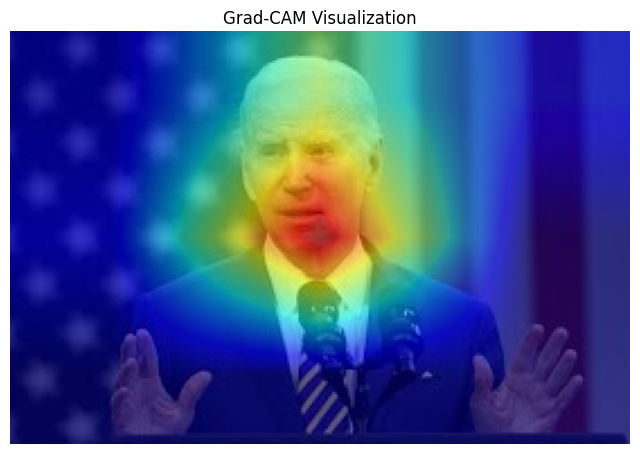

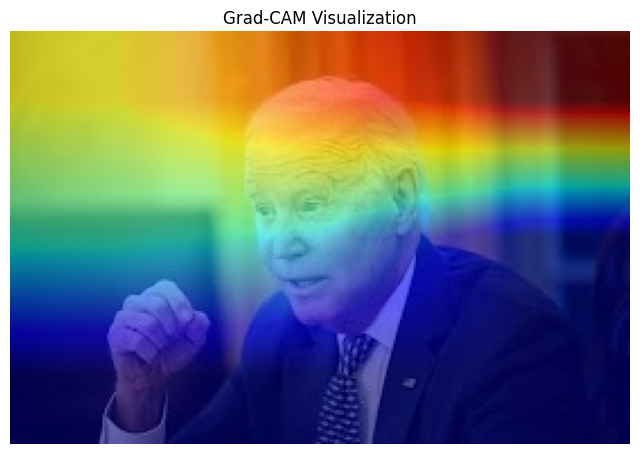

Cosine Similarity between the two faces: 0.8327


In [ ]:
#### Gradcam: compare to faces


import torch
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine

def initialize_mtcnn():
    mtcnn = MTCNN(image_size=160, margin=20, min_face_size=40)
    return mtcnn

def initialize_facenet():
    model = InceptionResnetV1(pretrained='vggface2').eval()
    return model

def process_image(image_path, mtcnn):
    image = Image.open(image_path)
    face = mtcnn(image)
    if face is None:
        raise ValueError("No face detected! Try again!")
    return face

def embeddings(model, face_tensor):
    face_tensor = face_tensor.unsqueeze(0)
    with torch.no_grad():
        embedding = model(face_tensor)
    return embedding.squeeze().numpy()

def compare_images(embedding1, embedding2):
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

def generate_gradcam(model, face_tensor, target_layer):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks to capture gradients and activations
    hook_backward = target_layer.register_backward_hook(backward_hook)
    hook_forward = target_layer.register_forward_hook(forward_hook)

    # Perform a forward pass
    face_tensor = face_tensor.unsqueeze(0)
    face_tensor.requires_grad = True
    output = model(face_tensor)

    # Compute gradient of a representative neuron (mean of output)
    target_neuron = output.mean()
    target_neuron.backward()

    # Extract gradients and activations
    activations = activations[0].detach()
    gradients = gradients[0].detach()

    # Calculate Grad-CAM heatmap
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
    gradcam = torch.sum(weights * activations, dim=1).squeeze()
    gradcam = torch.relu(gradcam)

    # Normalize heatmap
    gradcam = gradcam - gradcam.min()
    gradcam = gradcam / gradcam.max()

    # Remove hooks
    hook_backward.remove()
    hook_forward.remove()

    return gradcam

def plot_gradcam_on_face(original_image, gradcam, face_tensor):
    gradcam_np = gradcam.numpy()

    # Resize Grad-CAM heatmap to match original image dimensions
    gradcam_resized = np.array(
        Image.fromarray(gradcam_np).resize(original_image.size, resample=Image.BILINEAR)
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(original_image)
    plt.imshow(gradcam_resized, cmap='jet', alpha=0.6)  # Overlay heatmap
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()

def highlight_important_areas(gradcam, threshold=0.01):
    # Identify and mask areas with importance above the threshold
    important_mask = gradcam > threshold
    return important_mask

if __name__ == "__main__":
    image1 = "biden1.jpg"
    image2 = "biden2.jpg"

    mtcnn = initialize_mtcnn()
    model = initialize_facenet()

    # Select target layer for Grad-CAM
    target_layer = model.block8

    try:
        # Process images
        face1 = process_image(image1, mtcnn)
        face2 = process_image(image2, mtcnn)

        # Generate Grad-CAM heatmaps
        gradcam1 = generate_gradcam(model, face1, target_layer)
        gradcam2 = generate_gradcam(model, face2, target_layer)

        # Plot Grad-CAM heatmaps on the original images
        original_image1 = Image.open(image1)
        original_image2 = Image.open(image2)

        plot_gradcam_on_face(original_image1, gradcam1, face1)
        plot_gradcam_on_face(original_image2, gradcam2, face2)

        # Compute embeddings and similarity
        embedding1 = embeddings(model, face1)
        embedding2 = embeddings(model, face2)

        similarity = compare_images(embedding1, embedding2)
        print(f"Cosine Similarity between the two faces: {similarity:.4f}")

        # Highlight areas most important for identification
        important_mask1 = highlight_important_areas(gradcam1)
        important_mask2 = highlight_important_areas(gradcam2)


    except ValueError as e:
        print(e)



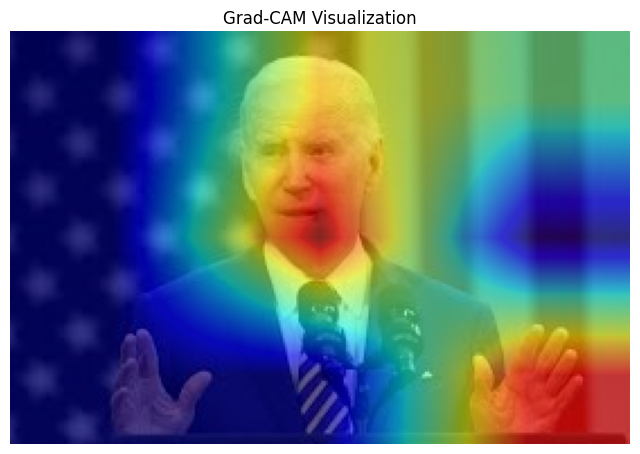

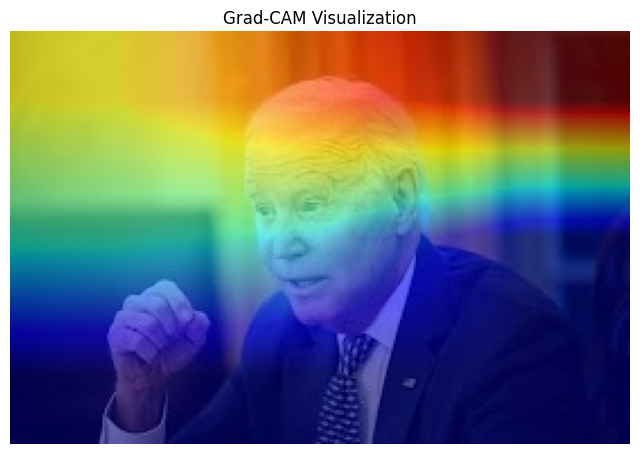

Cosine Similarity between the two faces: 0.8091


In [ ]:
#### Gradcam: compare two faces, but with edited Biden

import torch
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine

def initialize_mtcnn():
    mtcnn = MTCNN(image_size=160, margin=20, min_face_size=40)
    return mtcnn

def initialize_facenet():
    model = InceptionResnetV1(pretrained='vggface2').eval()
    return model

def process_image(image_path, mtcnn):
    image = Image.open(image_path)
    face = mtcnn(image)
    if face is None:
        raise ValueError("No face detected! Try again!")
    return face

def embeddings(model, face_tensor):
    face_tensor = face_tensor.unsqueeze(0)
    with torch.no_grad():
        embedding = model(face_tensor)
    return embedding.squeeze().numpy()

def compare_images(embedding1, embedding2):
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

def generate_gradcam(model, face_tensor, target_layer):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks to capture gradients and activations
    hook_backward = target_layer.register_backward_hook(backward_hook)
    hook_forward = target_layer.register_forward_hook(forward_hook)

    # Perform a forward pass
    face_tensor = face_tensor.unsqueeze(0)
    face_tensor.requires_grad = True
    output = model(face_tensor)

    # Compute gradient of a representative neuron (mean of output)
    target_neuron = output.mean()
    target_neuron.backward()

    # Extract gradients and activations
    activations = activations[0].detach()
    gradients = gradients[0].detach()

    # Calculate Grad-CAM heatmap
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
    gradcam = torch.sum(weights * activations, dim=1).squeeze()
    gradcam = torch.relu(gradcam)

    # Normalize heatmap
    gradcam = gradcam - gradcam.min()
    gradcam = gradcam / gradcam.max()

    # Remove hooks
    hook_backward.remove()
    hook_forward.remove()

    return gradcam

def plot_gradcam_on_face(original_image, gradcam, face_tensor):
    gradcam_np = gradcam.numpy()

    # Resize Grad-CAM heatmap to match original image dimensions
    gradcam_resized = np.array(
        Image.fromarray(gradcam_np).resize(original_image.size, resample=Image.BILINEAR)
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(original_image)
    plt.imshow(gradcam_resized, cmap='jet', alpha=0.6)  # Overlay heatmap
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()

def highlight_important_areas(gradcam, threshold=0.01):
    # Identify and mask areas with importance above the threshold
    important_mask = gradcam > threshold
    return important_mask

if __name__ == "__main__":
    image1 = "biden edited.jpg"
    image2 = "biden2.jpg"

    mtcnn = initialize_mtcnn()
    model = initialize_facenet()

    # Select target layer for Grad-CAM
    target_layer = model.block8

    try:
        # Process images
        face1 = process_image(image1, mtcnn)
        face2 = process_image(image2, mtcnn)

        # Generate Grad-CAM heatmaps
        gradcam1 = generate_gradcam(model, face1, target_layer)
        gradcam2 = generate_gradcam(model, face2, target_layer)

        # Plot Grad-CAM heatmaps on the original images
        original_image1 = Image.open(image1)
        original_image2 = Image.open(image2)

        plot_gradcam_on_face(original_image1, gradcam1, face1)
        plot_gradcam_on_face(original_image2, gradcam2, face2)

        # Compute embeddings and similarity
        embedding1 = embeddings(model, face1)
        embedding2 = embeddings(model, face2)

        similarity = compare_images(embedding1, embedding2)
        print(f"Cosine Similarity between the two faces: {similarity:.4f}")

        # Highlight areas most important for identification
        important_mask1 = highlight_important_areas(gradcam1)
        important_mask2 = highlight_important_areas(gradcam2)


    except ValueError as e:
        print(e)



<ipython-input-55-53ada154636b>:24: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if perturbed_image.grad is None:


No gradients computed for perturbed_image!
Cosine Similarity with PGD adversarial perturbation (guided by Grad-CAM): 0.7087


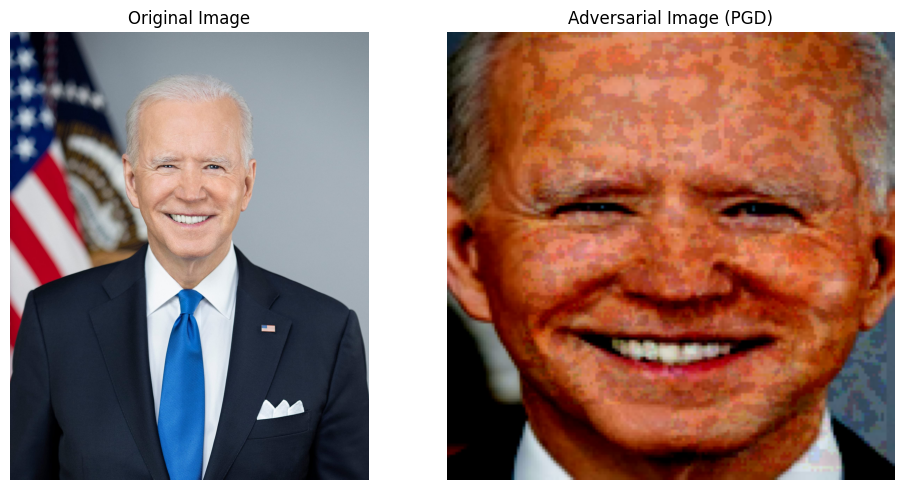

In [ ]:
######## PGD ##############
epsilon = 0.05
num_steps = 100  # Number of PGD steps

def pgd_attack_with_gradcam(image, epsilon, num_steps, data_grad, gradcam_map):
    gradcam_map = gradcam_map / gradcam_map.max()  # Normalize Grad-CAM map
    gradcam_map = gradcam_map.clone().detach().unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

    # Resize Grad-CAM map to match gradient dimensions
    gradcam_resized = F.interpolate(gradcam_map, size=data_grad.shape[1:], mode='bilinear', align_corners=False)

    # Focus gradients using Grad-CAM
    focused_grad = data_grad * gradcam_resized.squeeze(0)  # Remove batch dimension after resizing

    # Ensure the perturbed image is a leaf tensor and can track gradients
    perturbed_image = image.clone().detach().requires_grad_(True)  # Ensure it's a leaf tensor with requires_grad=True

    for _ in range(num_steps):
        # Forward pass
        output = model(perturbed_image.unsqueeze(0))
        target_neuron = output.mean()  # Use mean as a proxy target (e.g., similarity score)

        # Backward pass
        model.zero_grad()  # Clear previous gradients
        target_neuron.backward()

        # Debugging: Check if gradients are computed
        if perturbed_image.grad is None:
            print("No gradients computed for perturbed_image!")
            break

        # Get gradients of the input image
        data_grad = perturbed_image.grad.data

        # Update the perturbed image
        perturbed_image = perturbed_image + epsilon * focused_grad.sign()

        # Clip to valid range [0, 1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

def generate_targeted_pgd_adversarial_image(model, face_tensor, gradcam_map, epsilon, num_steps=10):
    # Ensure face_tensor is a leaf tensor that tracks gradients
    face_tensor = face_tensor.clone().detach().requires_grad_(True)  # Detach and set requires_grad=True

    # Forward pass
    output = model(face_tensor.unsqueeze(0))
    target_neuron = output.mean()  # Use mean as a proxy target (e.g., similarity score)

    # Backward pass
    model.zero_grad()  # Clear previous gradients
    target_neuron.backward()

    # Get gradients of the input image
    if face_tensor.grad is None:
        print("No gradients computed for face_tensor!")
        return None

    data_grad = face_tensor.grad.data

    # Generate adversarial image with PGD focusing on Grad-CAM regions
    perturbed_image = pgd_attack_with_gradcam(face_tensor, epsilon, num_steps, data_grad, gradcam_map)
    return perturbed_image

if __name__ == "__main__":
    image2 = "joe_biden.jpeg"

    mtcnn = initialize_mtcnn()
    model = initialize_facenet()

    target_layer = model.block8  # Use the same target layer for Grad-CAM

    try:
        original_image = Image.open(image2)  # Load original image

        # Process original image to obtain a face
        face = process_image(image2, mtcnn)

        # Compute Grad-CAM map
        gradcam_map = gradcam(model, face, target_layer)  # Renamed variable

        # Compute embeddings for original face
        embedding1 = embeddings(model, face)

        # Generate adversarial example using PGD guided by Grad-CAM regions
        adversarial_face_pgd = generate_targeted_pgd_adversarial_image(model, face, gradcam_map, epsilon, num_steps)

        if adversarial_face_pgd is not None:
            # Compute embeddings for adversarial face
            embedding_adv_pgd = embeddings(model, adversarial_face_pgd)

            # Compare embeddings
            similarity_adv_pgd = compare_images(embedding1, embedding_adv_pgd)
            print(f"Cosine Similarity with PGD adversarial perturbation (guided by Grad-CAM): {similarity_adv_pgd:.4f}")

            # Convert the adversarial image tensor to a NumPy array for visualization
            if isinstance(adversarial_face_pgd, torch.Tensor):
                adversarial_face_pgd = adversarial_face_pgd.squeeze().cpu().detach().numpy()
                if adversarial_face_pgd.shape[0] == 3:
                    adversarial_face_pgd = np.moveaxis(adversarial_face_pgd, 0, -1)  # Convert from [C, H, W] to [H, W, C]

            # Display both the original and adversarial images
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            # Show original image
            axes[0].imshow(original_image)
            axes[0].set_title("Original Image")
            axes[0].axis('off')  # Hide axes

            # Show adversarial image
            axes[1].imshow(adversarial_face_pgd)
            axes[1].set_title("Adversarial Image (PGD)")
            axes[1].axis('off')  # Hide axes

            plt.tight_layout()
            plt.show()

        else:
            print("Failed to generate adversarial image.")

    except ValueError as e:
        print(e)